In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [7]:
#add anomaly data

#load anomaly detection model
anomalyDetector = tf.keras.models.load_model('AE_tuneActivation_code_relu.h5')

anomalyData = []

for index, row in all_df.iterrows():
    sensorReadings = np.array([row['Volt'], row['Rotate'], row['Pressure'], row['Vibration']])
    sensorReadings = np.reshape(sensorReadings, (1,4))
    predictions = anomalyDetector.predict(sensorReadings)
    anomalyScore = (np.mean(np.power(sensorReadings - predictions, 2), axis=1))**0.5
    
    if anomalyScore < 0.0838:
        isAnomaly = 0
    else:
        isAnomaly = 1
        
    anomalyData.append(isAnomaly)
    
all_df['Anomalous'] = anomalyData

In [8]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL,Anomalous
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0,0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0,0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0,0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0,0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0,0
...,...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0,0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0,0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0,0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0,1


In [9]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['Anomalous'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [10]:
data_split

[[[0.0, 0.379151092, 0.556385187, 0.243079506, 0.229504293, 0.0, 9.0, 0.0],
  [1.0, 0.415506993, 0.698561103, 0.242410288, 0.273824561, 0.0, 8.0, 1.0],
  [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 0.0, 7.0, 2.0],
  [3.0, 0.343817356, 0.627731997, 0.233904513, 0.264566349, 0.0, 6.0, 2.0],
  [4.0, 0.310361557, 0.607368113, 0.194295643, 0.240200195, 0.0, 5.0, 2.0],
  [5.0, 0.336327636, 0.531479142, 0.215693485, 0.215780325, 0.0, 4.0, 2.0],
  [6.0, 0.397831149, 0.57521239, 0.190585546, 0.230599092, 0.0, 3.0, 2.0],
  [7.0, 0.385974096, 0.630933953, 0.208516333, 0.247693397, 0.0, 2.0, 2.0],
  [8.0, 0.376943194, 0.396047283, 0.215659658, 0.256992779, 1.0, 1.0, 3.0],
  [9.0, 0.56498231, 0.648197926, 0.516587151, 0.256162471, 1.0, 0.0, 4.0]],
 [[10.0, 0.351867147, 0.647795783, 0.257161825, 0.276671218, 0.0, 12.0, 0.0],
  [11.0, 0.353867353, 0.615858294, 0.197009134, 0.269388231, 0.0, 11.0, 0.0],
  [12.0, 0.384169823, 0.622861995, 0.199791766, 0.305659257, 0.0, 10.0, 0.0],
  [13.0,

In [11]:
#set random seed 
tf.random.set_seed(42)

In [12]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

In [13]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [14]:
train_data

[[[0.0, 0.379151092, 0.556385187, 0.243079506, 0.229504293, 0.0, 9.0, 0.0],
  [1.0, 0.415506993, 0.698561103, 0.242410288, 0.273824561, 0.0, 8.0, 1.0],
  [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 0.0, 7.0, 2.0],
  [3.0, 0.343817356, 0.627731997, 0.233904513, 0.264566349, 0.0, 6.0, 2.0],
  [4.0, 0.310361557, 0.607368113, 0.194295643, 0.240200195, 0.0, 5.0, 2.0],
  [5.0, 0.336327636, 0.531479142, 0.215693485, 0.215780325, 0.0, 4.0, 2.0],
  [6.0, 0.397831149, 0.57521239, 0.190585546, 0.230599092, 0.0, 3.0, 2.0],
  [7.0, 0.385974096, 0.630933953, 0.208516333, 0.247693397, 0.0, 2.0, 2.0],
  [8.0, 0.376943194, 0.396047283, 0.215659658, 0.256992779, 1.0, 1.0, 3.0],
  [9.0, 0.56498231, 0.648197926, 0.516587151, 0.256162471, 1.0, 0.0, 4.0]],
 [[10.0, 0.351867147, 0.647795783, 0.257161825, 0.276671218, 0.0, 12.0, 0.0],
  [11.0, 0.353867353, 0.615858294, 0.197009134, 0.269388231, 0.0, 11.0, 0.0],
  [12.0, 0.384169823, 0.622861995, 0.199791766, 0.305659257, 0.0, 10.0, 0.0],
  [13.0,

In [15]:
def getSensorReadingsOnlyNoEpisode(lst):
    result = []
    time = []
    for episode in lst:
        for row in episode:
            row_formatted = row[1:6]
            result.append(row_formatted)
            time.append(row[0])
    return (result, time)

In [16]:
def getRULFromDataNoEpisode(lst):
    RULresult = []
    for episode in lst:
        for row in episode:
            RULresult.append(row[6])
    return RULresult

In [17]:
#drop episodes with random failure in training set
train_data_cleaned = []
for train_episode in train_data:
    lastState = train_episode[-1][-1]
    if lastState < 5:
        train_data_cleaned.append(train_episode)

In [18]:
SVR_trainX, SVR_trainTime = getSensorReadingsOnlyNoEpisode(train_data_cleaned)
SVR_trainY = getRULFromDataNoEpisode(train_data_cleaned)
SVR_valX, SVR_valTime = getSensorReadingsOnlyNoEpisode(val_data)
SVR_valY = getRULFromDataNoEpisode(val_data)
SVR_testX, SVR_testTime = getSensorReadingsOnlyNoEpisode(test_data)
SVR_testY = getRULFromDataNoEpisode(test_data)

In [19]:
#change to arr 
SVR_trainX_arr = np.array(SVR_trainX)
SVR_trainY_arr = np.array(SVR_trainY)
SVR_valX_arr = np.array(SVR_valX)
SVR_valY_arr = np.array(SVR_valY)
SVR_testX_arr = np.array(SVR_testX)
SVR_testY_arr = np.array(SVR_testY)

In [20]:
SVR_trainX_all, SVR_trainTime_all = getSensorReadingsOnlyNoEpisode(train_data)
SVR_trainY_all = getRULFromDataNoEpisode(train_data)

In [21]:
SVR_trainX_all_arr = np.array(SVR_trainX_all)
SVR_trainY_all_arr = np.array(SVR_trainY_all)

In [22]:
#check shape (training) X
SVR_trainX_arr.shape

(5362, 5)

In [23]:
#check shape (training) Y
SVR_trainY_arr.shape

(5362,)

In [24]:
#check shape (validation) X
SVR_valX_arr.shape

(967, 5)

In [25]:
#check shape (validation) Y
SVR_valY_arr.shape

(967,)

In [26]:
SVRmodel = SVR(kernel='rbf',degree=4,gamma='auto',C=98.818,epsilon=0.978)
SVRmodel.fit(SVR_trainX_arr, SVR_trainY_arr)

SVR(C=98.818, degree=4, epsilon=0.978, gamma='auto')

In [27]:
#evaluate performance of training set 
SVR_trainPredict = SVRmodel.predict(SVR_trainX_all_arr)
SVR_trainRMSE = math.sqrt(mean_squared_error(SVR_trainY_all_arr, SVR_trainPredict))
SVR_trainR2Score = r2_score(SVR_trainY_all_arr, SVR_trainPredict)
SVR_trainSscore = findSscore(SVR_trainY_all_arr, SVR_trainPredict)
print("RMSE of training set is %f, R2 score of training set is %f, S score of training set is %f" % (SVR_trainRMSE, SVR_trainR2Score, SVR_trainSscore))

RMSE of training set is 4.687558, R2 score of training set is 0.134003, S score of training set is 8402.823571


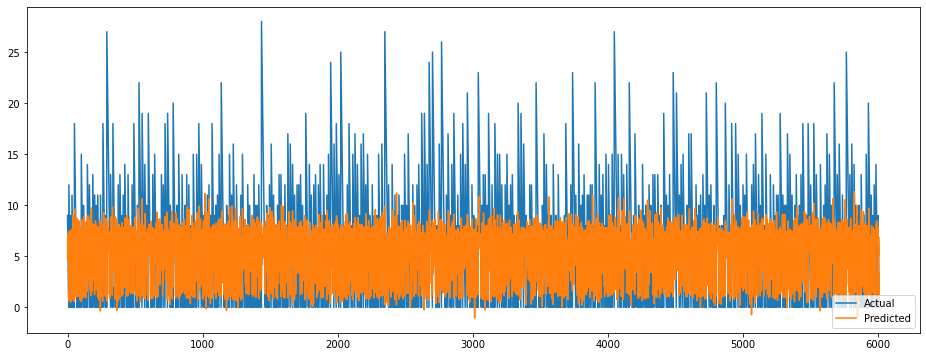

In [28]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY_all_arr)
plt.plot(SVR_trainPredict)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

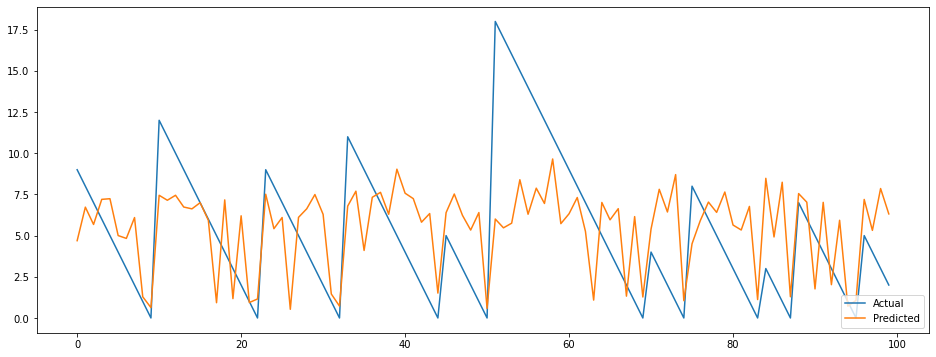

In [29]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY_all_arr[0:100])
plt.plot(SVR_trainPredict[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

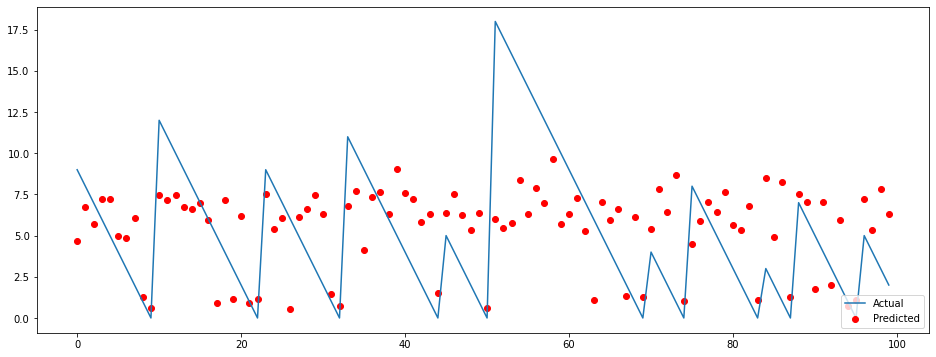

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainTime_all[0:100], SVR_trainY_all_arr[0:100])
plt.scatter(SVR_trainTime_all[0:100], SVR_trainPredict[0:100], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

In [31]:
#evaluate performance of validation set 
SVR_valPredict = SVRmodel.predict(SVR_valX_arr)
SVR_valRMSE = math.sqrt(mean_squared_error(SVR_valY_arr, SVR_valPredict))
SVR_valR2Score = r2_score(SVR_valY_arr, SVR_valPredict)
SVR_valSscore = findSscore(SVR_valY_arr, SVR_valPredict)
print("RMSE of validation set is %f, R2 score of validation set is %f, S score of validation set is %f" % (SVR_valRMSE, SVR_valR2Score, SVR_valSscore))

RMSE of validation set is 3.853206, R2 score of validation set is 0.185770, S score of validation set is 1288.810491


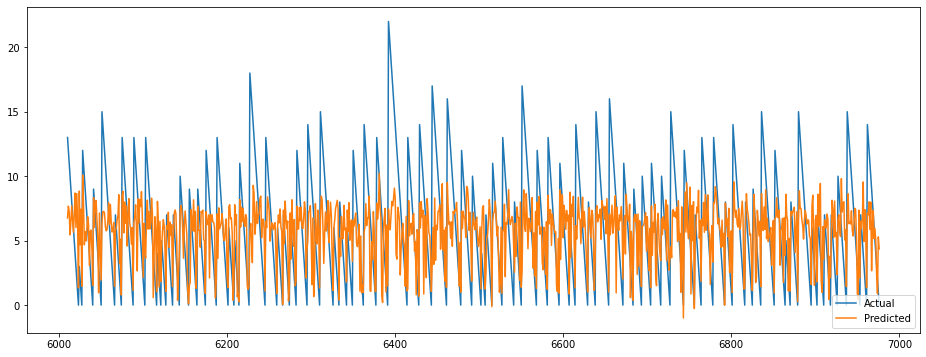

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime, SVR_valY_arr)
plt.plot(SVR_valTime, SVR_valPredict)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

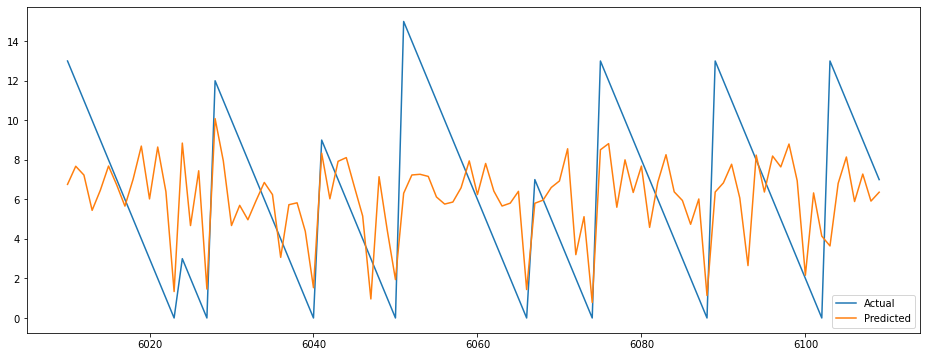

In [33]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime[0:100], SVR_valY_arr[0:100])
plt.plot(SVR_valTime[0:100], SVR_valPredict[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

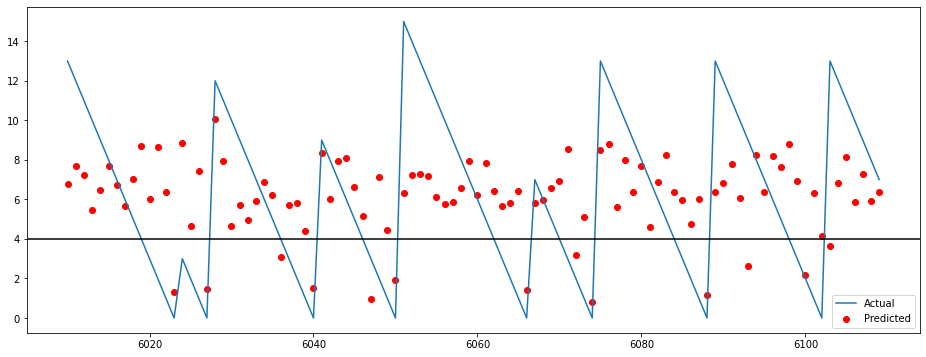

In [34]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime[0:100], SVR_valY_arr[0:100])
plt.scatter(SVR_valTime[0:100], SVR_valPredict[0:100], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()